# Committee Meeting 18 Sept

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
#from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [3]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [4]:
term2_ds_CT = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2_CT = term2_ds_CT.ct_e_z2_filt.rename('term2')
term3_CT = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [5]:
term2_ds_SA = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2_SA = term2_ds_SA.sa_e_z2_filt.rename('term2')
term3_SA = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()

In [22]:
K_e_CT = K_rho*(term2_CT/term3_CT)
K_e_SA = K_rho*(term2_SA/term3_SA**2)

In [24]:
CT_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc')
CT_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc')
CT2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc')

In [15]:
SA_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_meso_VPR.nc')
SA_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_micro_VPR.nc')
SA2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa2_frac.nc')

In [25]:
dCT_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')
dCT_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

In [27]:
dSA_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_dx.nc')
dSA_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_dy.nc')

In [29]:
F_CT_x = -K_e_CT*dCT_dx
F_CT_y = -K_e_CT*dCT_dy
F_CT_xy = K_e_CT*np.sqrt(dCT_dx**2 + dCT_dy**2)

In [30]:
F_SA_x = -K_e_SA*dSA_dx
F_SA_y = -K_e_SA*dSA_dy
F_SA_xy = K_e_SA*np.sqrt(dSA_dx**2 + dSA_dy**2)

In [40]:
def interp_to_pmean(var_profile, pres_profile, pmean_grid, roll):
    
    pres_da = xr.DataArray(pres_profile, dims=['rho_grid'])
    pmean_smooth = pres_da.rolling(rho_grid=roll, center=True).mean()

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        #print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [41]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], ds_rho['PRES'],
                                   input_core_dims=[['rho_grid'], ['rho_grid']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF','pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'N_PROF': ds_rho.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(lat  = ('N_PROF', ds_rho.lat.data))
    ds_pmean = ds_pmean.assign_coords(lon = ('N_PROF', ds_rho.lon.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = ('N_PROF', ds_rho.TIME.data))
    
    return ds_pmean

In [8]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/ds_rho_hydro.nc')

In [35]:
ds_rho['K_e_CT'] = (('rho_grid','lon','lat'), K_e_CT.data)
ds_rho['K_e_SA'] = (('rho_grid','lon','lat'), K_e_SA.data)

ds_rho['CT_meso_VPR'] = (('rho_grid','lon','lat'), CT_meso_VPR.data)
ds_rho['CT_micro_VPR'] = (('rho_grid','lon','lat'), CT_micro_VPR.data)
ds_rho['CT2_frac_VPR'] = (('rho_grid','lon','lat'), CT2_frac_VPR.data)

ds_rho['SA_meso_VPR'] = (('rho_grid','lon','lat'), SA_meso_VPR.data)
ds_rho['SA_micro_VPR'] = (('rho_grid','lon','lat'), SA_micro_VPR.data)
ds_rho['SA2_frac_VPR'] = (('rho_grid','lon','lat'), SA2_frac_VPR.data)

ds_rho['dCT_dx'] = (('rho_grid','lon','lat'), dCT_dx.data)
ds_rho['dCT_dy'] = (('rho_grid','lon','lat'), dCT_dy.data)

ds_rho['dSA_dx'] = (('rho_grid','lon','lat'), dSA_dx.data)
ds_rho['dSA_dy'] = (('rho_grid','lon','lat'), dSA_dy.data)

ds_rho['F_CT_x'] = (('rho_grid','lon','lat'), F_CT_x.data)
ds_rho['F_CT_y'] = (('rho_grid','lon','lat'), F_CT_y.data)
ds_rho['F_CT_xy'] = (('rho_grid','lon','lat'), F_CT_xy.data)

ds_rho['F_SA_x'] = (('rho_grid','lon','lat'), F_SA_x.data)
ds_rho['F_SA_y'] = (('rho_grid','lon','lat'), F_SA_y.data)
ds_rho['F_SA_xy'] = (('rho_grid','lon','lat'), F_SA_xy.data)

In [37]:
ds_rho_line = ds_rho.stack(N_PROF=('lon','lat'))
ds_rho_line = ds_rho_line.reset_index('N_PROF')
ds_rho_line = ds_rho_line.assign_coords(lon = ('N_PROF', ds_rho_line.lon.data),
                                        lat = ('N_PROF', ds_rho_line.lat.data))

In [59]:
np.linspace(0,2000,1001)

array([   0.,    2.,    4., ..., 1996., 1998., 2000.])

In [60]:
ds_pean_line = get_ds_pmean(ds_rho_line, np.linspace(0,2000,1001), 
                            ['CT','SA','SIG0','SPICE','PRES','K_e_CT','K_e_SA',
                            'CT_meso_VPR','CT_micro_VPR','CT2_frac_VPR',
                            'SA_meso_VPR','SA_micro_VPR','SA2_frac_VPR',
                            'dCT_dx','dCT_dy','dSA_dx','dSA_dy',
                            'F_CT_x','F_CT_y','F_CT_xy',
                            'F_SA_x','F_SA_y','F_SA_xy'], roll=150)

ERROR! Session/line number was not unique in database. History logging moved to new session 1128
Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed comp for K_e_CT
Completed K_e_CT
Completed comp for K_e_SA
Completed K_e_SA
Completed comp for CT_meso_VPR
Completed CT_meso_VPR
Completed comp for CT_micro_VPR
Completed CT_micro_VPR
Completed comp for CT2_frac_VPR
Completed CT2_frac_VPR
Completed comp for SA_meso_VPR
Completed SA_meso_VPR
Completed comp for SA_micro_VPR
Completed SA_micro_VPR
Completed comp for SA2_frac_VPR
Completed SA2_frac_VPR
Completed comp for dCT_dx
Completed dCT_dx
Completed comp for dCT_dy
Completed dCT_dy
Completed comp for dSA_dx
Completed dSA_dx
Completed comp for dSA_dy
Completed dSA_dy
Completed comp for F_CT_x
Completed F_CT_x
Completed comp for F_CT_y
Completed F_CT_y
Completed comp for F_CT_xy
Completed F_CT_xy

In [61]:
ds_pmean = ds_pean_line.set_index(N_PROF=['lat', 'lon']).unstack('N_PROF')

In [62]:
ds_pmean = ds_pmean.rename({'pmean_grid':'pbar'})

In [63]:
ds_pmean_150 = xr.open_dataset('/swot/SUM05/amf2288/ds_pmean_150_hyrdo.nc')

## Hydrography

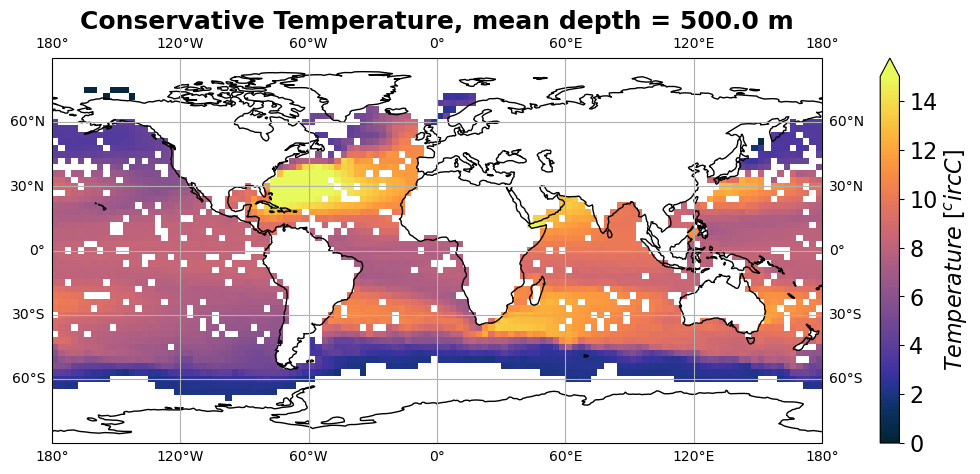

In [134]:
depth = 500
title = 'Conservative Temperature'
name = '$Temperature$'
units = '$^circ C$'
ds = ds_pmean.CT.copy(data=ds_pmean.CT)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.thermal, colors.Normalize(vmin=0, vmax=15)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

## Eddy Diffusivity

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_72797/2547823428.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Conservative Temperature'


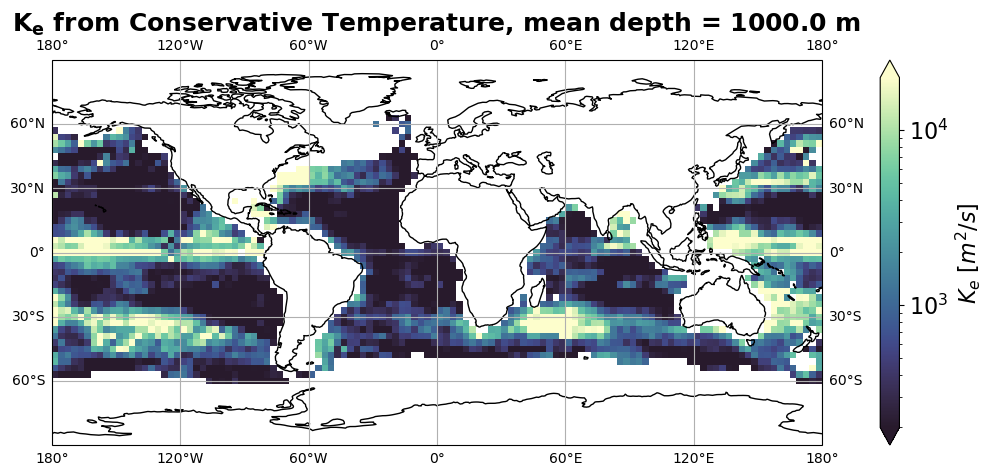

In [144]:
depth = 1000
title = '$\mathbf{{K_e}}$ from Conservative Temperature'
name = '$K_e$'
units = '$m^2/s$'
ds = ds_pmean.K_e_CT.copy(data=ds_pmean.K_e_CT)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=10**2.3, vmax=10**4.3)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_72797/303853083.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Absolute Salinity'


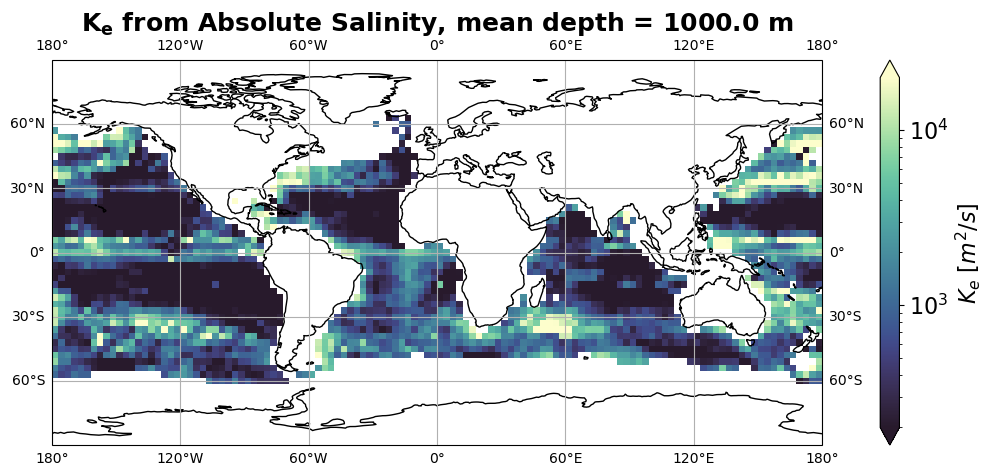

In [145]:
depth = 1000
title = '$\mathbf{{K_e}}$ from Absolute Salinity'
name = '$K_e$'
units = '$m^2/s$'
ds = ds_pmean.K_e_SA.copy(data=ds_pmean.K_e_SA)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=10**2.3, vmax=10**4.3)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

## Variance Production

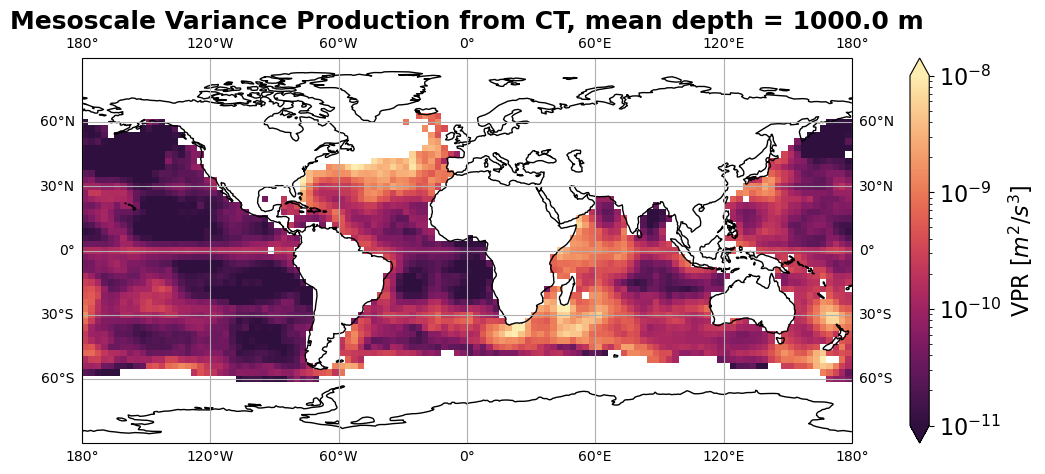

In [146]:
depth = 1000
title = 'Mesoscale Variance Production from CT'
name = 'VPR'
units = '$m^2/s^3$'
ds = ds_pmean.CT_meso_VPR.copy(data=ds_pmean.CT_meso_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

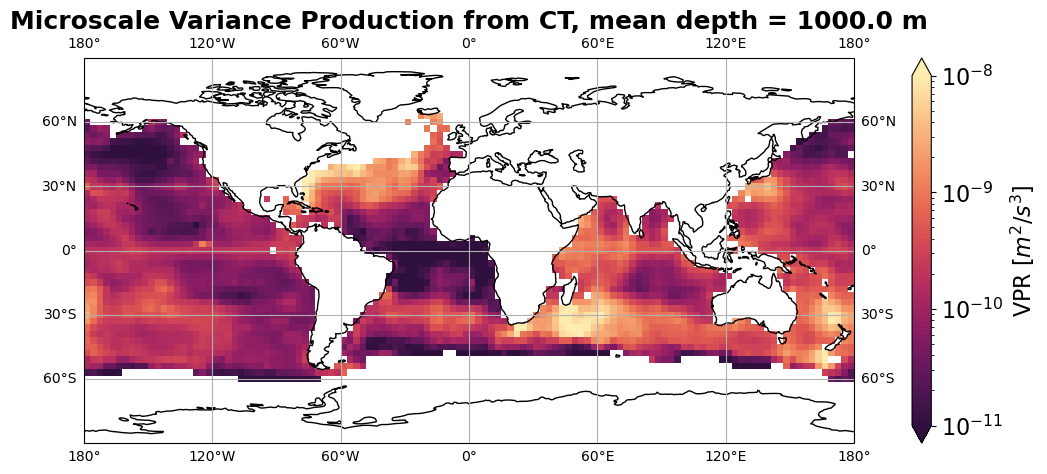

In [147]:
depth = 1000
title = 'Microscale Variance Production from CT'
name = 'VPR'
units = '$m^2/s^3$'
ds = ds_pmean.CT_micro_VPR.copy(data=ds_pmean.CT_micro_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

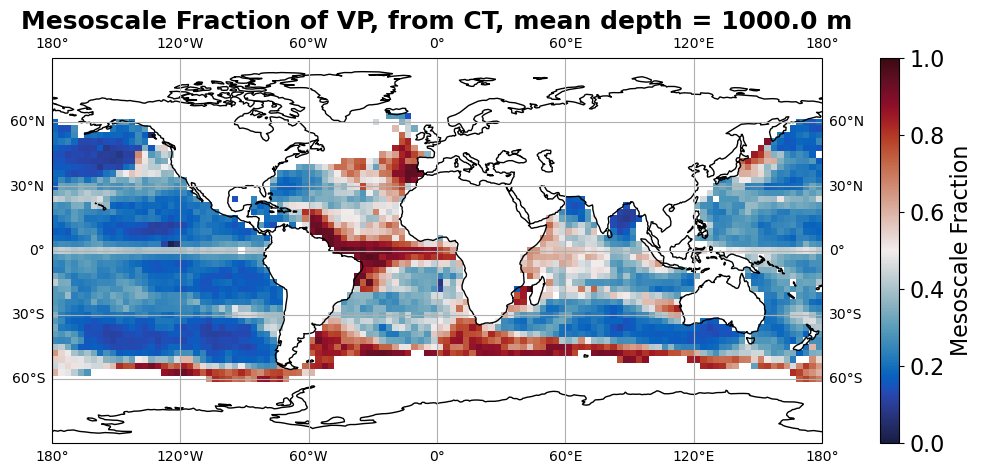

In [148]:
depth = 1000
title = 'Mesoscale Fraction of VP, from CT'
name = 'Mesoscale Fraction'
ds = ds_pmean.CT2_frac_VPR.copy(data=ds_pmean.CT2_frac_VPR)
ds.name = name
cmap, norm = cmo.balance, colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

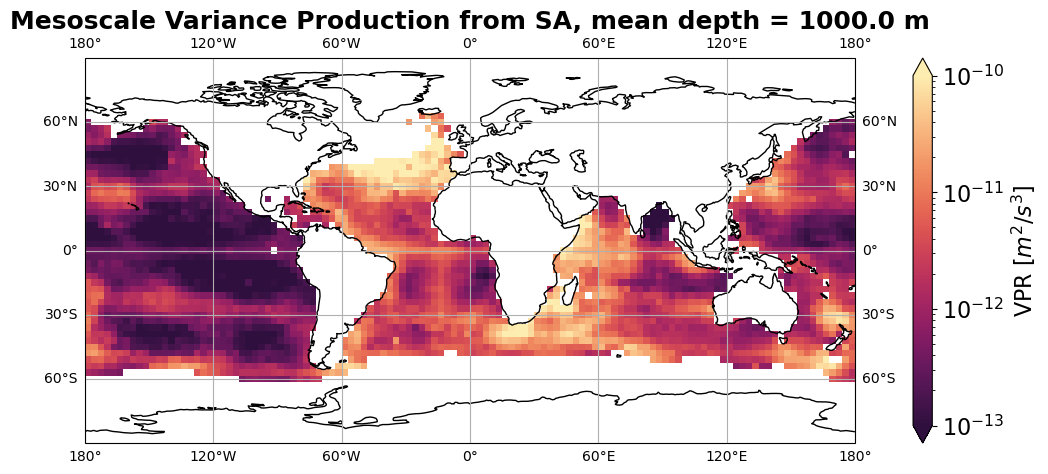

In [150]:
depth = 1000
title = 'Mesoscale Variance Production from SA'
name = 'VPR'
units = '$m^2/s^3$'
ds = ds_pmean.SA_meso_VPR.copy(data=ds_pmean.SA_meso_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-13, vmax=1e-10)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

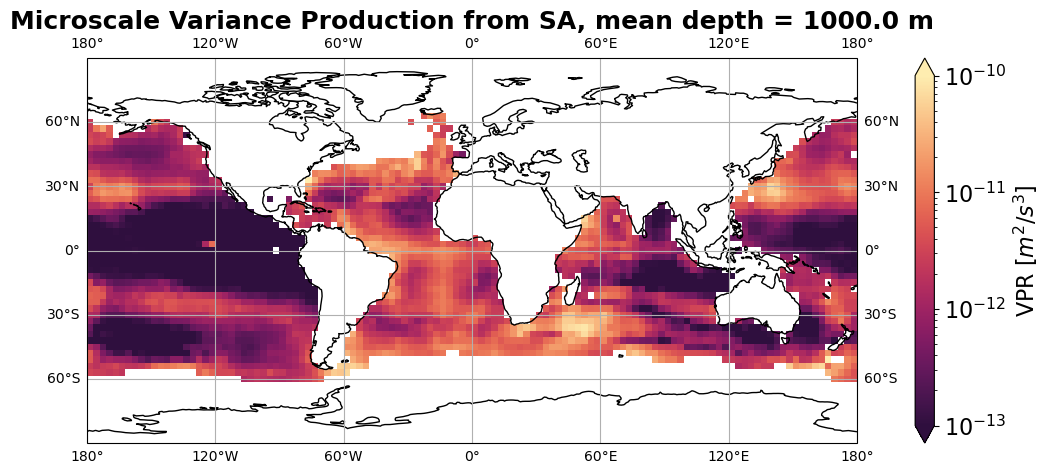

In [151]:
depth = 1000
title = 'Microscale Variance Production from SA'
name = 'VPR'
units = '$m^2/s^3$'
ds = ds_pmean.SA_micro_VPR.copy(data=ds_pmean.SA_micro_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-13, vmax=1e-10)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

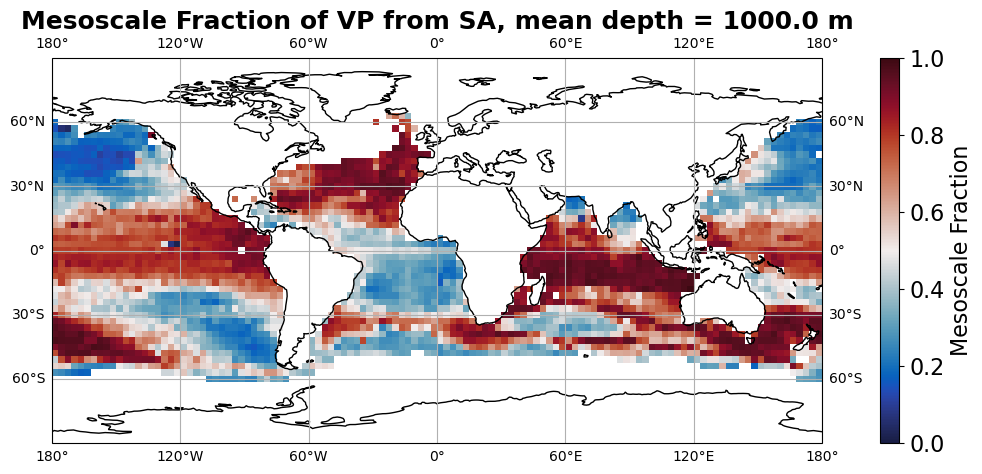

In [152]:
depth = 1000
title = 'Mesoscale Fraction of VP from SA'
name = 'Mesoscale Fraction'
ds = ds_pmean.SA2_frac_VPR.copy(data=ds_pmean.SA2_frac_VPR)
ds.name = name
cmap, norm = cmo.balance, colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

## Temperature Flux

In [98]:
# Choose a density slice—here using index, but you could use `.sel(density=...)` too
u = ds_pmean.dCT_dx.sel(pbar=500, method='nearest')
v = ds_pmean.dCT_dy.sel(pbar=500, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

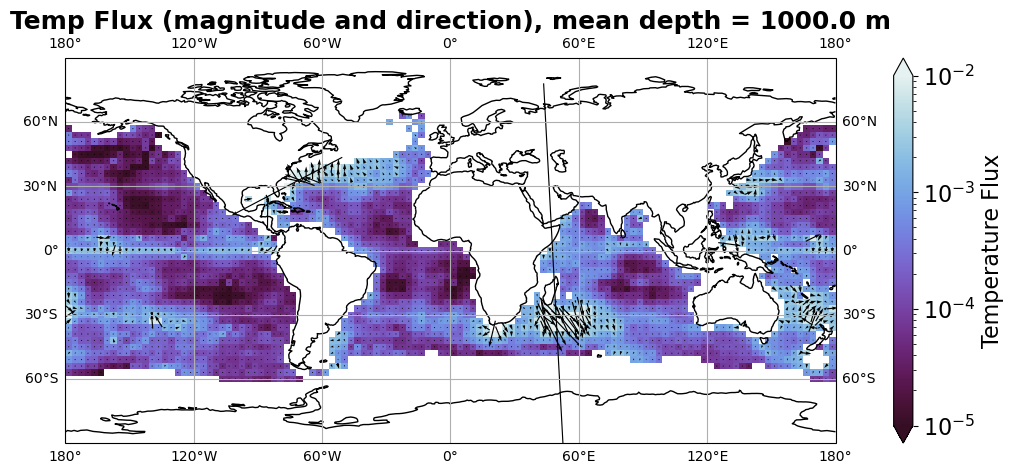

In [157]:
depth = 1000
title = 'Temp Flux (magnitude and direction)'
name = 'Temperature Flux'
ds = ds_pmean.F_CT_xy.copy(data=ds_pmean.F_CT_xy)
ds.name = name
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-2)

# Choose a density slice—here using index, but you could use `.sel(density=...)` too
u = ds_pmean.F_CT_x.sel(pbar=depth, method='nearest')
v = ds_pmean.F_CT_y.sel(pbar=depth, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
q = ax.quiver(XX, YY, U, V, scale=0.4, pivot='middle', width=0.0015)
#ax.quiverkey(q, X=0.7, Y=0.08, U=5e-6, label=f'{5e-7:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
#ax.quiverkey(q, X=0.7, Y=0.04, U=1e-5, label=f'{1e-6:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");

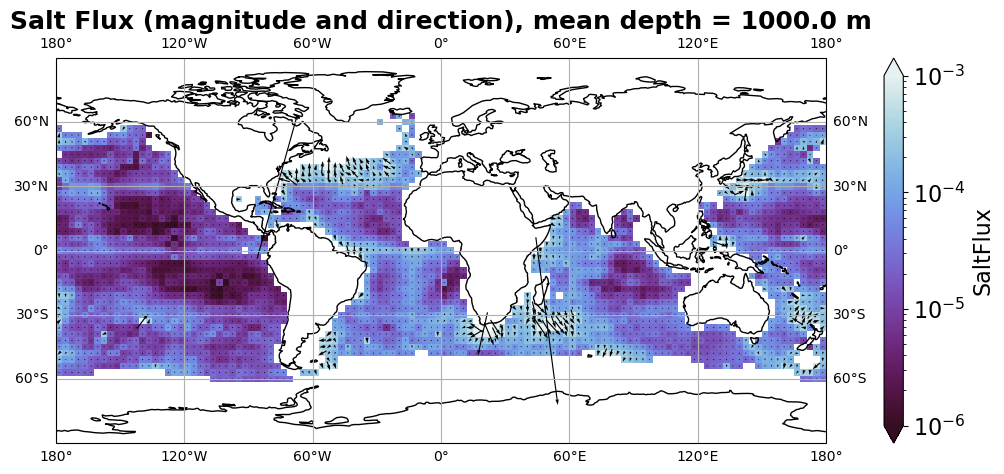

In [162]:
depth = 1000
title = 'Salt Flux (magnitude and direction)'
name = 'SaltFlux'
ds = ds_pmean.F_SA_xy.copy(data=ds_pmean.F_SA_xy)
ds.name = name
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-6, vmax=1e-3)

# Choose a density slice—here using index, but you could use `.sel(density=...)` too
u = ds_pmean.F_SA_x.sel(pbar=depth, method='nearest')
v = ds_pmean.F_SA_y.sel(pbar=depth, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(pbar=depth, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
q = ax.quiver(XX, YY, U, V, scale=0.05, pivot='middle', width=0.0015)
#ax.quiverkey(q, X=0.7, Y=0.08, U=5e-6, label=f'{5e-7:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
#ax.quiverkey(q, X=0.7, Y=0.04, U=1e-5, label=f'{1e-6:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.set_title(f"{title}, mean depth = {ds.pbar.sel(pbar=depth, method='nearest').values.item()} m");